# Exact GP playground

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import malt
import abc
import gpytorch

Using backend: pytorch


### Testing

In [2]:
torch.manual_seed(1)

In [3]:
import torch
import dgl
import malt

from malt.models.regressor import GPyTorchExactRegressor
from malt.data.collections import linear_alkanes, esol

# get data
la_data = linear_alkanes()
la_data = esol()
la_data.shuffle()
# make dataset bigger ....

train_x, train_y = la_data.batch()
# train_y = train_y.ravel()

# create model
model = malt.models.supervised_model.GaussianProcessSupervisedModel(
    representation=malt.models.representation.DGLRepresentation(
        out_features=32, hidden_features=32,
    ),
    regressor=GPyTorchExactRegressor(
        in_features=32,
        out_features=2,
        train_targets=train_y,
    ),
    likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
).cuda()

# define marginal log likelihood
from malt.models.marginal_likelihood import ExactMarginalLogLikelihood
from malt.models.likelihood import HeteroschedasticGaussianLikelihood

# likelihood = HeteroschedasticGaussianLikelihood()
# mll = ExactMarginalLogLikelihood(likelihood, net)
# likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.regressor.likelihood, model)

# define optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=1e-3)

ImportError: cannot import name 'GPyTorchExactRegressor' from 'malt.models.regressor' (c:\users\micha\dev\choderalab\malt\malt\models\regressor.py)

In [26]:
from tqdm import tqdm
def train(model, optimizer, mll):
    loss_history = []
    train_iter = 100
    model.train()
    for i in tqdm(range(train_iter)):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y).mean()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    return model, loss_history

In [27]:
def test(model, test_x, test_y):
    from scipy.stats import pearsonr
    model.eval()
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        preds = model(test_x)

    rmse = torch.sqrt(torch.mean(torch.pow(preds.mean - test_y, 2))).item()
    mae = torch.mean(torch.abs(preds.mean - test_y)).item()
    corr, _ = pearsonr(preds.mean.tolist(), test_y.tolist())
    r2 = malt.metrics.base_metrics.r2(preds.loc, test_y).item()
    return rmse, mae, corr, r2

In [28]:
model.train()
model, loss_history = train(model, optimizer, mll)
model.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(train_x).loc
rmse, mae, corr, r2 = test(model, train_x, train_y)
print('rmse:', rmse, '\nmae:', mae, '\ncorr:', corr, '\nr2:', r2)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.67it/s]


rmse: 2.3341455459594727 
mae: 1.8450672626495361 
corr: [0.6024757630454255] 
r2: 0.3494410514831543


In [38]:
model.eval()
model(train_x).loc

tensor([-1.7456, -4.4019, -1.3440,  ..., -1.5245, -0.2975, -4.1911],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [39]:
train_y

tensor([-0.8300, -3.7300, -1.1000,  ..., -1.8100, -0.5500, -3.6700],
       device='cuda:0')

In [15]:
# import gpytorch
# likelihood = gpytorch.likelihoods.GaussianLikelihood()
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, net)

# output = net.condition(g)
# output = gpytorch.distributions.MultivariateNormal(output.loc.cpu(), output.covariance_matrix.cpu())
# print(-mll(output, y.cpu()).mean())

# Test with ESOL

In [32]:
%load_ext autoreload
%autoreload 2

import torch
import dgl
import malt
import argparse
import gpytorch

parser = argparse.ArgumentParser()
parser.add_argument("--data", type=str,
                    # default="esol",
                    default="freesolv",
)
parser.add_argument("--model", type=str, default="gp")

args = parser.parse_args([])

data = getattr(malt.data.collections, args.data)()

def test(data):
    
    data.shuffle(seed=1)
    ds_tr, ds_te = data.split([0.8, 0.2])
    # ds_tr, _ = ds_tr_vl.split([0.9, 0.1])
    
    if args.model == "gp":
        model = malt.models.supervised_model.GaussianProcessSupervisedModel(
            representation=malt.models.representation.DGLRepresentation(
                out_features=32, hidden_features=32,
            ),
            regressor=malt.models.regressor.ExactGaussianProcessRegressor(
                train_targets=ds_tr.batch(by='y'), in_features=32, out_features=2,
            ),
            likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
        ).cuda()


    elif args.model == "nn":
        model = malt.models.supervised_model.SimpleSupervisedModel(
            representation=malt.models.representation.DGLRepresentation(
                out_features=32,
            ),
            regressor=malt.models.regressor.NeuralNetworkRegressor(
                in_features=32, out_features=1,
            ),
            likelihood=malt.models.likelihood.HomoschedasticGaussianLikelihood(),
        ).cuda()


    trainer = malt.trainer.get_default_trainer(
        without_player=True,
        n_epochs=100,
        learning_rate=1e-3,
        validation_split=0.0,
    )
    
    mll = malt.models.marginal_likelihood.ExactMarginalLogLikelihood(
        model.likelihood,
        model
    )
    
    # mll = gpytorch.mlls.ExactMarginalLogLikelihood(
    #     model.regressor.likelihood,
    #     model
    # )
    
    # return model
    model = trainer(model, ds_tr, mll)

    # model_cpu = model.to('cpu')
    model.eval()
    r2_te = malt.metrics.supervised_metrics.R2()(model, ds_te)
    r2_tr = malt.metrics.supervised_metrics.R2()(model, ds_tr)
    return r2_tr, r2_te, model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Processing dgl graphs from scratch...


In [110]:
from tqdm import tqdm

r2_trs = []
r2_tes = []
for _ in tqdm(range(10)):
    r2_tr, r2_te, model = test(data)
    r2_trs.append(r2_tr)
    r2_tes.append(r2_te)

100%|███████████████████████████████████████████| 10/10 [01:14<00:00,  7.42s/it]


In [112]:
[r.item() for r in r2_trs]

[0.9889549612998962,
 0.9880563020706177,
 0.9909041523933411,
 0.991159975528717,
 0.9904177784919739,
 0.988492488861084,
 0.9893581867218018,
 0.9850164651870728,
 0.9894757866859436,
 0.9905683994293213]

Text(0.5, 1.0, 'R^2 [test] | Hard-coded Exact GP')

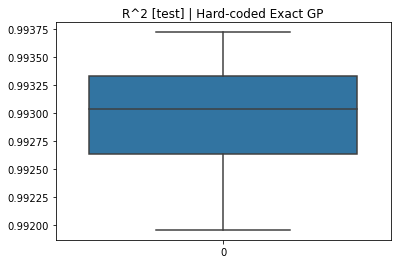

In [106]:
import seaborn as sns

g = sns.boxplot(data=[r.item() for r in r2_trs])
g.set_title('R^2 [test] | Hard-coded Exact GP')

In [90]:
ds_tr, ds_te = data.split([0.8, 0.2])
# ds_tr, _ = ds_tr_vl.split([0.9, 0.1])
model.eval()
r2 = malt.metrics.supervised_metrics.R2()(model, ds_te)
r2

tensor(0.9705, device='cuda:0')

In [51]:
ds_tr, ds_te = data.split([9, 1])
g, y = ds_tr.batch()
model.eval()

y_preds = model(g)

In [52]:
y_preds.loc

tensor([-0.0505, -0.0505, -0.0505,  ..., -0.0505, -0.0505, -0.0505],
       device='cuda:0', grad_fn=<ExpandBackward0>)

In [2]:
# data.shuffle(seed=1)
# ds_tr, ds_te = data.split([8, 2])
# train_targets = ds_tr.batch(by='y')

# reg = malt.models.regressor.ExactGaussianProcessRegressor(
#     train_targets=train_targets,
#     in_features=32,
#     out_features=2,
# )

In [3]:
# ds_tr, ds_te = data.split([9, 1])
# g, y = ds_tr.batch()
# model.representation(g).shape

In [14]:
ds_tr_vl, ds_te = data.split([0.9, 0.1])
ds_tr, _ = ds_tr_vl.split([0.9, 0.1])

In [17]:
ds_tr

Dataset with 913 molecules

In [13]:
ds_tr_vl

NameError: name 'ds_tr_vl' is not defined

In [8]:
data.shuffle(seed=1)
ds_tr_vl, ds_te = data.split([0.9, 0.1])
ds_tr, _ = ds_tr_vl.split([0.9, 0.1])

print(ds_tr.batch(by='y').shape)

if args.model == "gp":
    model = malt.models.supervised_model.GaussianProcessSupervisedModel(
        representation=malt.models.representation.DGLRepresentation(
            out_features=32, hidden_features=32,
        ),
        regressor=malt.models.regressor.ExactGaussianProcessRegressor(
            train_targets=ds_tr.batch(by='y'), in_features=32, out_features=2,
        ),
        likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
    ).cuda()


elif args.model == "nn":
    model = malt.models.supervised_model.SimpleSupervisedModel(
        representation=malt.models.representation.DGLRepresentation(
            out_features=32,
        ),
        regressor=malt.models.regressor.NeuralNetworkRegressor(
            in_features=32, out_features=1,
        ),
        likelihood=malt.models.likelihood.HomoschedasticGaussianLikelihood(),
    ).cuda()


trainer = malt.trainer.get_default_trainer(
    without_player=True,
    batch_size=len(ds_tr_vl),
    n_epochs=100,
    learning_rate=1e-3,
)

mll = malt.models.marginal_likelihood.ExactMarginalLogLikelihood(
    model.likelihood,
    model
)

# return model
model = trainer(model, ds_tr_vl, mll)

# model_cpu = model.to('cpu')
r2 = malt.metrics.supervised_metrics.R2()(model, ds_te)

torch.Size([913, 1])


NameError: name 'math' is not defined